# Reading and constructing constraints

In [253]:
import matplotlib.pyplot as plt

from smamp.insertHbyList import insertHbyList
from smamp.tools import read_atom_numbers
from smamp.tools import read_total_charge

import h5py
import ase
import warnings
import sys
import ast
import argparse
import os
import ase.io
import parmed as pmd
import numpy as np
import pandas as pd

In [3]:
def create_structure(infile_pdb, infile_top, strip_string=':SOL,CL', implicitHbondingPartners = None):
        
    if implicitHbondingPartners is None:
        implicitHbondingPartners = read_atom_numbers()
        
    ua_ase_struct = ase.io.read(infile_pdb)
    ua_pmd_struct = pmd.load_file(infile_pdb)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ua_pmd_top = pmd.gromacs.GromacsTopologyFile(infile_top,parametrize=False)

    ua_pmd_top.strip(strip_string)
        #strip water and electrolyte from system (if not yet done in .top)
    ua_pmd_top.box = ua_pmd_struct.box # Needed because .pdb contains box info
    ua_pmd_top.positions = ua_pmd_struct.positions

    ua_names = [ a.name for a in ua_pmd_top.atoms ]
    ua_residues = [ a.residue.name for a in ua_pmd_top.atoms ]

    aa_ase_struct, aa_pmd_struct, aa_names, aa_residues = \
        insertHbyList(ua_ase_struct,ua_pmd_top,
        implicitHbondingPartners,1.0)

    ua_count = len(ua_ase_struct)     # united atoms structure
    aa_count = len(aa_ase_struct) # all atoms structure

    ua_ase_index = np.arange(ua_count)
    aa_ase_index = np.arange(aa_count)

    aa_atom_residue_list = list(zip(aa_names,aa_residues))
    aa_ase_index = range(aa_count)
    aa_ase2pmd = dict(zip(aa_ase_index,aa_atom_residue_list))
    aa_pmd2ase = dict(zip(aa_atom_residue_list,aa_ase_index))

    ua_atom_residue_list = list(zip(ua_names,ua_residues))
    ua_ase_index = range(ua_count)
    ua_ase2pmd = dict(zip(ua_ase_index,ua_atom_residue_list))
    ua_pmd2ase = dict(zip(ua_atom_residue_list,ua_ase_index))

    # TODO: distinction for ua and aa fitting:
    pmd_struct = ua_pmd_struct
    pmd_top = ua_pmd_top
    ase2pmd = ua_ase2pmd
    pmd2ase = ua_pmd2ase
    return pmd_struct, pmd_top, ase2pmd, pmd2ase

In [53]:
infile_pdb = "200_ps_snapshot/0_initial_structure/snapshot.pdb"
infile_top = "200_ps_snapshot/0_initial_structure/example.top"
infile_cost_h5 = "horton_charges/costfunction_average.h5"
infile_atoms_in_cg_csv = "con_test/atoms_in_charge_group.csv"
infile_cg_charges_csv = "con_test/charge_group_total_charge.csv"
infile_atoms_of_same_charge_csv = "con_test/atoms_of_same_charge.csv",
qtot = 1
strip_string=':SOL,CL'    

In [54]:
pmd_struct, pmd_top, ase2pmd, pmd2ase = create_structure(infile_pdb, infile_top)
print(ase2pmd[0])
print(pmd2ase[('CE1', 'terB')])

('CE1', 'terB')
0


In [56]:
def read_AtomName_ChargeGroup(file_name, ase2pmd):
    
    ase2pmd_df = pd.DataFrame(ase2pmd).T
    ase2pmd_df.columns = ['atom','residue']

    pmd2cg_df = pd.read_csv(file_name, sep=',', header=None,
                            comment='#', names=['atom','cg'])

    unique_residues = ase2pmd_df['residue'].unique()
    unique_charge_groups = pmd2cg_df['cg'].unique()

    cg2ase = []
    for cgtype in unique_charge_groups:    
        for r in unique_residues:
            names_in_cg = pmd2cg_df[pmd2cg_df['cg'] == cgtype]['atom']
            cg_sel = ase2pmd_df['atom'].isin(names_in_cg)
            res_sel = (ase2pmd_df['residue'] == r )

            new_cg = ase2pmd_df[cg_sel & res_sel]

            if not new_cg.empty:
                cg2ase.append(new_cg.index.values)

    return cg2ase

cg2ase = read_AtomName_ChargeGroup(file_name=infile_atoms_in_cg_csv, ase2pmd=ase2pmd)
print(cg2ase)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56]), array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95, 96])]


In [227]:
def read_charge_groups(file_name, ase2pmd):
    # first we read in the textfile
    df = pd.read_csv(file_name, sep=',', header=None,
                            comment='#', names=['atom','cg'])
    
    # Atoms appear in multiple charge groups.
    # In the end, we want something like
    # {cg1: [1, 5, 8]}
    charge_groups = {}
    for atom in df.atom:
        # cg is the charge group of the current atom
        cg = df.loc[df.atom == atom].cg.values[0]
        if not cg in charge_groups.keys():
            charge_groups[cg] = []        
        
        # ase2pmd is formatted like
        # 0: ('CE1', 'terB')
        for ase_index, atom_residuum in ase2pmd.items():
                # If the atom names match, pick the ase index            
                if atom in atom_residuum:
                    charge_groups[cg] += [ase_index]
    # Sort everything                
    for ase_index in charge_groups.keys():
        charge_groups[ase_index].sort()
    
    return charge_groups

charge_groups = read_charge_groups(file_name=infile_atoms_in_cg_csv, ase2pmd=ase2pmd)
print(charge_groups)

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]}


In [265]:
def read_ChargeGroup_TotalCharge(file_name):
    group_q = pd.read_csv(file_name, sep=',', header=None, comment='#',
                          names=['charge'], index_col=0)
    group_q.charge = group_q.charge.astype(int)    
    return group_q

group_q = read_ChargeGroup_TotalCharge(file_name=infile_cg_charges_csv)
print(group_q)

   charge
1       0
2       0
3       0


In [249]:
def construct_charge_group_constraints(charge_groups, group_q, n_atoms):
    
    # Initialize empty arrays
    D_matrix = np.zeros((len(charge_groups), n_atoms), dtype=int)
    Q_vector = np.zeros(len(charge_groups), dtype=int)
    
    # Fill in constraint values for every charge group
    for ase_index in charge_groups.keys():
        cg = charge_groups[ase_index]
        # Note: Charge groups are [1, 2, ...], np indices are [0, 1, ..]
        # 1 means that the sum of q_i in the charge group is unweighted
        D_matrix[ase_index - 1, cg] = 1
       
        # Now we need to specify the total charge of the group in a vector
        total_group_charge = group_q.loc[ase_index]
        Q_vector[ase_index - 1] = total_group_charge

    return D_matrix, Q_vector

construct_charge_group_constraints(charge_groups, group_q, n_atoms)

(array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([5, 1]))

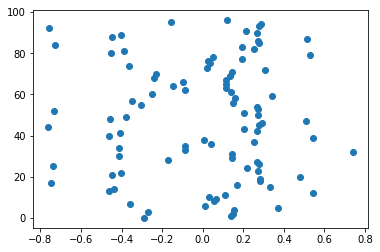

In [358]:
from refactored_fitESPconstrained import *
A, B = read_horton_cost_function(infile_cost_h5)

n_atoms = len(ase2pmd)
group_q = read_ChargeGroup_TotalCharge(file_name=infile_cg_charges_csv)
charge_groups = read_charge_groups(file_name=infile_atoms_in_cg_csv, ase2pmd=ase2pmd)

D_matrix, Q_vector = construct_charge_group_constraints(charge_groups, group_q, n_atoms)

q, f = constrained_minimize(A, B, D=D_matrix, Q=Q_vector)

plt.plot(q, range(len(q)), lw=0, marker='o')
plt.show()

In [298]:
def constructPairwiseSymmetryConstraints(charges, N, symmetry=1.0, debug=False):

    D = []
    q = []

    # loop over sets of equally charged atoms
    for charge_list in charges:
        M = len(charge_list)-1 # number of pairwise constraints for the current list

        #symmetry = symmetry*np.ones(M)


        D_single = np.atleast_2d(np.zeros((M,N)))
        q_single = np.atleast_1d(np.zeros(M))
        D_single[:,charge_list[0]] = 1 # 1st atom in list used in every constraint

        for j in range(M):
            D_single[j,charge_list[j+1]] = -1.0*symmetry

        #add up D_single and q_single to D and q
        D.append(D_single)
        q.append(q_single)

    D,q = concatenated_constraints(D,q)
    return D, q



In [392]:
def parse_symmetry(file_name)
    df = pd.read_csv(file_name, sep=',', header=None,  comment='#')
    symm_names = df.values.tolist()
    return symm_names
                
def symmetry_names_to_index_groups(symm_names, ase2pmd):
    """Transform atom-name based constraints into index-based constraints."""
    symm_groups = []
    for i in range(len(symm_names)):
        names = symm_names[i]
        symm_groups += [[]]
        for ase_index, atom_residuum in ase2pmd.items():
            # If the atom names match, pick the ase index 
            atom_name = atom_residuum[0]
            if names[0] == atom_name:
                # Every member of this group is supposed to have equal charge           
                symm_groups[i] += [ase_index]
            if names[1] == atom_name:
                symm_groups[i] += [ase_index]
    return symm_groups
            
def symmetry_groups_to_matrix(symm_groups, n_atoms):
    """ Generate matrix-constraints from groups of same-charge indices.
    >>> groups = [[0, 2, 3]]
    >>> c = np.array([[1, 0, -1, 0, 0],
                      [1, 0, 0, -1, 0]])
    >>> symmetry_groups_to_matrix(groups, n_atoms=5)
    c
    """
    symm_list = []
    for group in symm_groups:
        for atom_index in group[1:]:
            matrix_row = np.zeros(n_atoms, dtype=int)
            matrix_row[group[0]] = 1
            matrix_row[atom_index] = -1
            symm_list += [matrix_row]

    symm_matrix = np.array(symm_list)
    return symm_matrix

symm_groups = symmetry_names_to_index_groups(symm_names, ase2pmd)
symm_matrix = symmetry_groups_to_matrix(symm_groups, n_atoms)

In [301]:

unique_atoms = ase2pmd_df['atom'].unique()
for a in unique_atoms:
    new_symmetry_group = ase2pmd_df[ ase2pmd_df['atom'] == a ]
    if not new_symmetry_group.empty:
        if len(new_symmetry_group.index.values) < 2:
            pass
        else:
            sym2ase.append(new_symmetry_group.index.values)

for i, group in sca_df.iterrows():
    sca_sel = ase2pmd_df['atom'].isin(group)
    new_symmetry_group = ase2pmd_df[sca_sel]

    if not new_symmetry_group.empty:
        sym2ase.append(new_symmetry_group.index.values)


atoms_in_charge_group.csv  charge_group_total_charge.csv  total_charge.csv
atoms_of_same_charge.csv   hydrogen_per_atom.csv
